<h3>Palantir analysis notebook</h3>

<h4>Table of contents</h4>
<br/>
<a href='#intro'>Introduction</a>
<br/>
<a href='#data'>Loading data</a>
<br/>
<a href='#pre'>Data preprocessing</a>
<br/>
<a href='#palantir'>Running Palantir</a>
<br/>
<a href='#palantir2'>Visualizing Palantir results</a>
<br/>
<a href='#trends'>Gene expression trends</a>
<br/>
<a href='#clustering'>Clustering of cells and gene expression trends</a>

<a id="intro"></a><h3> Introduction </h3>

Palantir is an algorithm to align cells along differentiation trajectories. Palantir models differentiation as a stochastic process where stem cells differentiate to terminally differentiated cells by a series of steps through a low dimensional phenotypic manifold. Palantir effectively captures the continuity in cell states and the stochasticity in cell fate determination. 

<a id="data"></a><h3> Loading data </h3>

Palantir can read single cell RNA-seq data from a csv file, mtx file, 10x counts and HDF files. The csv file should be a cells X genes matrix of counts.  This tutorial shows the usage with a csv file. 
The following code snippet imports the `palantir` package along with other plotting related imports

In [1]:
# Script for multiple runs of wanderlust 
%load_ext autoreload
%autoreload 2

In [2]:
import palantir

# Plotting and miscellaneous imports
import os
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

A sample RNA-seq csv data is available at `<palantir directory>/data/marrow_sample_scseq_counts.csv.gz`. This sample data will be used to demonstrate the utilization and capabilities of the Palantir package. This dataset contains ~4k cells and ~16k genes.

This is a subset of the data from the CD34+ cells from the human marrow, the dataset used in the manuscript.  The data comprises of progenitor Hematopoeitic stem cells and cells of the erythroid and myeloid lineages.

Assuming that Palantir was downloaded at `~/repositories/palantir`, the following snipped can be used to load the counts matrix.

In [3]:
# Load sample data
palantir_dir = os.path.expanduser('~/repositories/palantir/')
counts = palantir.io.from_csv(palantir_dir + 'data/marrow_sample_scseq_counts.csv.gz')

For alternative file formats, please use `palantir.io.from_mtx`, `palantir.io.from_10x`, `palantir.io.from_10x_HDF5` functions.

<h4> Data clean up </h4>

Palantir provides an interface for removing low molecule count cells and genes with low detection rates. The following snippet allows visualzation of molecule counts and gene detection rates

/usr/local/anaconda3/envs/dash/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


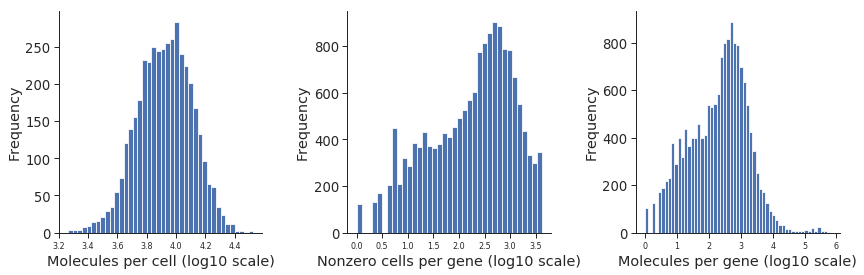

In [4]:
fig, ax = palantir.plot.plot_molecules_per_cell_and_gene(counts)

The dataset provided is already prefiltered. For other datasets, cells and genes can be filtered using

`filtered_counts = palantir.preprocess.filter_counts_data(counts, cell_min_molecules=1000, genes_min_cells=10)`

<h4> Normalization </h4>

The next step is to correct for molecule count distribution. Palantir divides the counts of each cell by the total molecules detected as a normalization  technique

In [5]:
norm_df = palantir.preprocess.normalize_counts(counts)

Data can be optionally log transformed. Note that, some datasets show better signal in the linear scale while others show stronger signal in the log scale. We use log transformation for this dataset

In [6]:
norm_df = palantir.preprocess.log_transform(norm_df)

<a id='pre'></a><h3>Data preprocessing</h3>

<h4> Principal component analysis </h4>

The first step in data processing for Palantir is to determine metagenes using principal component analysis. This representation is necessary to overcome the extensive dropouts that are pervasive in single cell RNA-seq data

In [7]:
pca_projections, _ = palantir.utils.run_pca(norm_df)

<h4> Diffusion maps </h4>

Palantir next determines the diffusion maps of the data as an estimate of the low dimensional phenotypic manifold of the data.

In [8]:
# Run diffusion maps
dm_res = palantir.utils.run_diffusion_maps(pca_projections, n_components=5)

Determing nearest neighbor graph...


The low dimensional embeddeing of the data is estimated based on the eigen  gap using the following function

In [9]:
ms_data = palantir.utils.determine_multiscale_space(dm_res)

If you are specifying the number of eigen vectors manually in the above step, please ensure that the specified parameter is > 2

<h4> tSNE visualization </h4>

Palantir constructs the tSNE map in the embedded space since these maps better represent the differentiation trajectories

In [10]:
tsne = palantir.utils.run_tsne(ms_data)

For consistency, the following snippet will load the precomputed `tSNE` projections.

In [11]:
import pandas as pd
tsne = pd.read_pickle(palantir_dir + 'data/sample_tsne.p')

tSNE results can be visualized by the `plot_tsne` and `plot_tsne_by_cell_sizes` functions. The `plot_tsne_by_cell_sizes` function colors the cells by their molecule counts before normalization

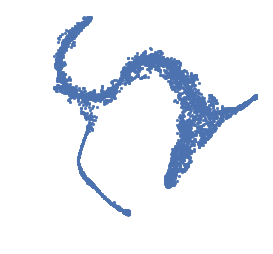

In [12]:
fig, ax = palantir.plot.plot_tsne(tsne)

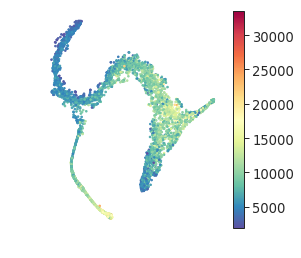

In [13]:
fig, ax = palantir.plot.plot_tsne_by_cell_sizes(counts, tsne)

<h4> MAGIC imputation </h4>

<a href="https://github.com/pkathail/magic">MAGIC</a> is an imputation technique developed in the Pe'er lab for single cell data imputation. Palantir uses MAGIC to impute the data for visualization and determining gene expression trends.

In [14]:
imp_df = palantir.utils.run_magic_imputation(norm_df, dm_res)

Gene expression can be visualized on tSNE maps using the `plot_gene_expression` function. The `genes` parameter is an string iterable of genes, which are a subset of the expression of column names. The below function plots the expression of HSC gene `CD34`, myeloid gene `MPO` and erythroid precursor gene `GATA1` and  dendritic cell gene `IRF8`. 

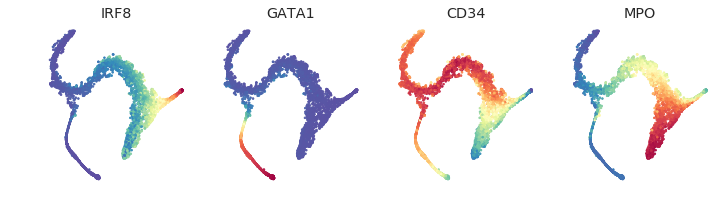

In [15]:
palantir.plot.plot_gene_expression(imp_df, tsne, ['CD34', 'MPO', 'GATA1', 'IRF8'])

<h4> Diffusion maps </h4>

The computed diffusion components can be visualized with the following snippet.

/usr/local/anaconda3/envs/dash/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


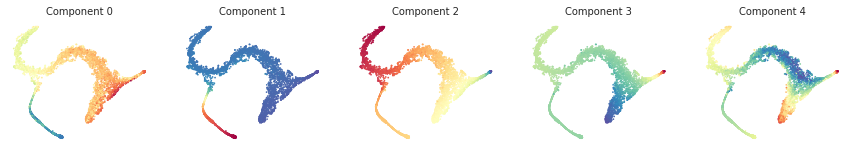

In [16]:
palantir.plot.plot_diffusion_components(tsne, dm_res)

<a id="palantir"></a><h3> Running Palantir </h3>

Palantir can be run by specifying an approxiate early cell. While Palantir automatically determines the terminal states, they can also specified using the `termine_states` parameter.

The start cell for this dataset was chosen based on high expression of CD34.

In [17]:
start_cell = 'Run5_164698952452459'
pr_res = palantir.core.run_palantir(ms_data, start_cell, num_waypoints=500)

Sampling and flocking waypoints...
Time for determining waypoints: 0.002625620365142822 minutes
Determining pseudotime...
Shortest path distances using 30-nearest neighbor graph...
Time for shortest paths: 0.1743042786916097 minutes
Iteratively refining the pseudotime...
Correlation at iteration 1: 0.9999
Entropy and branch probabilities...
Markov chain construction...
Identification of terminal states...
Computing fundamental matrix and absorption probabilities...
Project results to all cells...


/usr/local/anaconda3/envs/dash/lib/python3.7/site-packages/palantir/core.py:371: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  T[abs_states, :] = 0


Palantir generates the following results 
1. Pseudotime: Pseudo time ordering of each cell
2. Terminal state probabilities: Matrix of cells X terminal states. Each entry represents the probability of the corresponding cell reaching the respective terminal state
3. Entropy: A quantiative measure of the <i>differentiation potential</i> of each cell computed as the entropy of the multinomial terminal state probabilities

The terminal states in this dataset are renamed to reflect the known biology below

In [18]:
mapping = pd.Series(index=['DC', 'Mono', 'Ery'])
mapping['DC'] = tsne.loc[pr_res.branch_probs.columns, 'x'].idxmax()
mapping['Ery'] = tsne.loc[pr_res.branch_probs.columns, 'y'].idxmin()
mapping['Mono'] = pr_res.branch_probs.columns.difference(mapping.values)[0]
mapping = pd.Series(mapping.index, index=mapping)

In [19]:
pr_res.branch_probs.columns = mapping[pr_res.branch_probs.columns]
pr_res.branch_probs = pr_res.branch_probs.loc[:, ['Ery', 'Mono', 'DC']]

<a id="palantir2"></a><h3> Visualizing Palantir results </h3>

Palantir results can be visualized on the tSNE map using the `plot_palantir_results` function

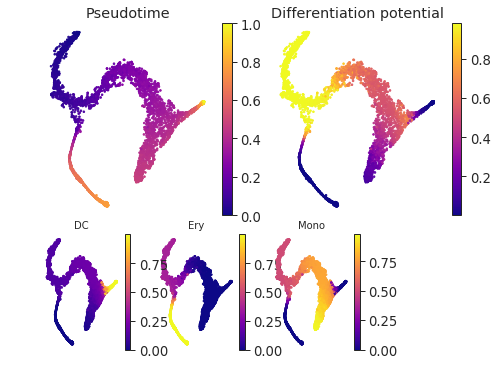

In [20]:
palantir.plot.plot_palantir_results(pr_res, tsne)

Terminal state probability distributions of individual cells can be visualized using the `plot_terminal_state_probs` function

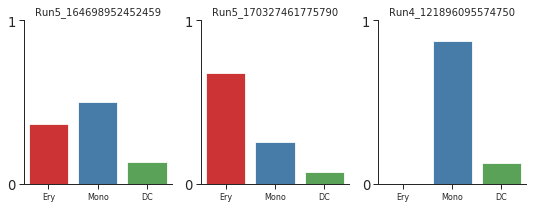

In [21]:
cells = ['Run5_164698952452459', 'Run5_170327461775790', 'Run4_121896095574750', ]
palantir.plot.plot_terminal_state_probs(pr_res, cells) 

The cells can be highlighted on the tSNE map using the `highlight_cells_on_tsne` function

(<Figure size 288x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a25c18748>)

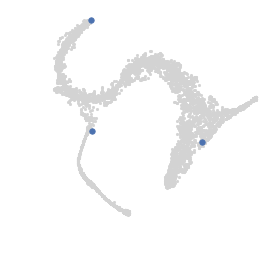

In [22]:
palantir.plot.highlight_cells_on_tsne(tsne, cells)

<a id='trends'></a><h3> Gene expression trends </h3>

Palantir uses <a href="https://cran.r-project.org/web/packages/gam/">Generalized Additive Models (GAMs) </a> to determine the gene expression trends along different lineages. The marker trends can be determined using the following snippet. This computes the trends for all lineages. A subset of lineages can be used using the `lineages` parameter.


In [23]:
genes = ['CD34', 'MPO', 'GATA1', 'IRF8']
gene_trends = palantir.presults.compute_gene_trends( pr_res, imp_df.loc[:, genes])

Ery
Time for processing Ery: 0.007820979754130045 minutes
Mono
Time for processing Mono: 0.00721358060836792 minutes
DC
Time for processing DC: 0.002470401922861735 minutes


The determined trends can be visualized with the `plot_gene_trends` function. A separate panel is generated  for each gene

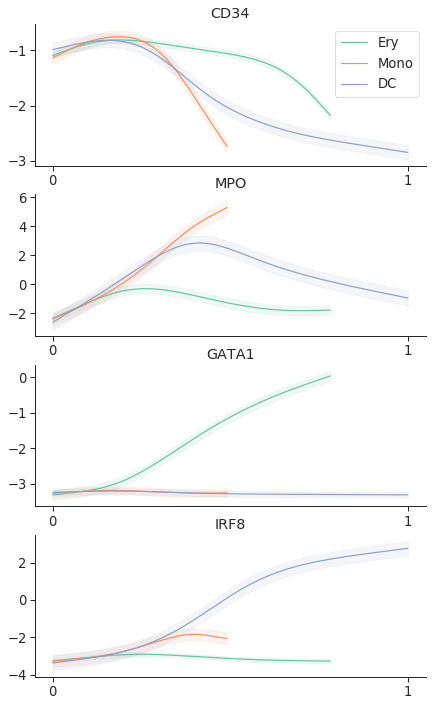

In [24]:
palantir.plot.plot_gene_trends(gene_trends)

Alternatively, the trends can be visualized on a heatmap using

/usr/local/anaconda3/envs/dash/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


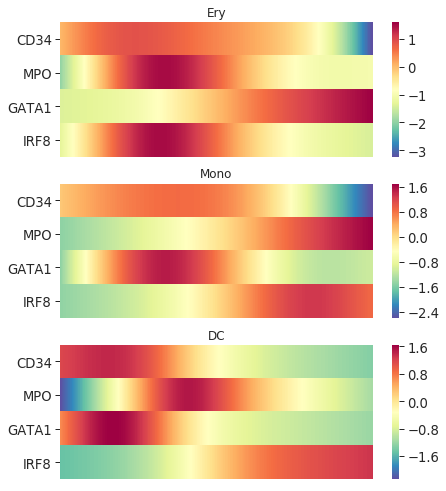

In [25]:
palantir.plot.plot_gene_trend_heatmaps(gene_trends)

<a id="clustering"></a><h3> Clustering </h3>

Cells can be clustered and visualized using <a href="https://github.com/dpeerlab/PhenoGraph">Phenograph</a> with the following snippet.

In [26]:
clusters = palantir.utils.determine_cell_clusters(pca_projections)

Finding 50 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.563600778579712 seconds
Jaccard graph constructed in 1.2693450450897217 seconds
Wrote graph to binary file in 0.9023759365081787 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.68001
Louvain completed 21 runs in 1.7906348705291748 seconds
PhenoGraph complete in 5.5563578605651855 seconds


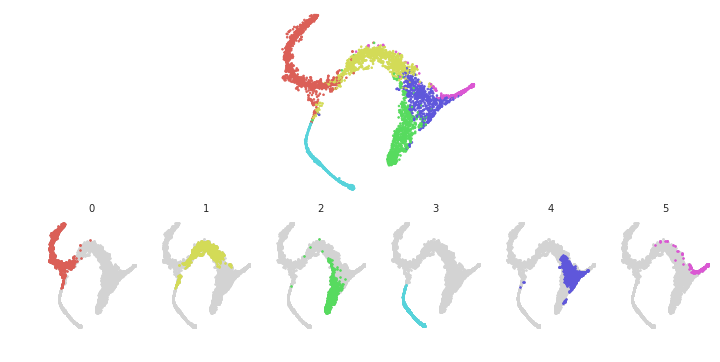

In [27]:
palantir.plot.plot_cell_clusters(tsne, clusters )

Similary, gene expression trends can be clustered and visualized using the following snippet. As an example, the first 1000 genes along the erythroid genes are clustered

In [28]:
gene_trends = palantir.presults.compute_gene_trends(pr_res, 
                    imp_df.iloc[:, 0:1000], ['Ery'])

Ery


/usr/local/anaconda3/envs/dash/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Time for processing Ery: 0.4920230189959208 minutes


In [29]:
# Cluster
trends = gene_trends['Ery']['trends']
gene_clusters = palantir.presults.cluster_gene_trends(trends)

Finding 150 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.11999678611755371 seconds
Jaccard graph constructed in 2.457261085510254 seconds
Wrote graph to binary file in 0.5954699516296387 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.60651
After 7 runs, maximum modularity is Q = 0.60782
Louvain completed 27 runs in 1.2136378288269043 seconds
PhenoGraph complete in 4.418212652206421 seconds


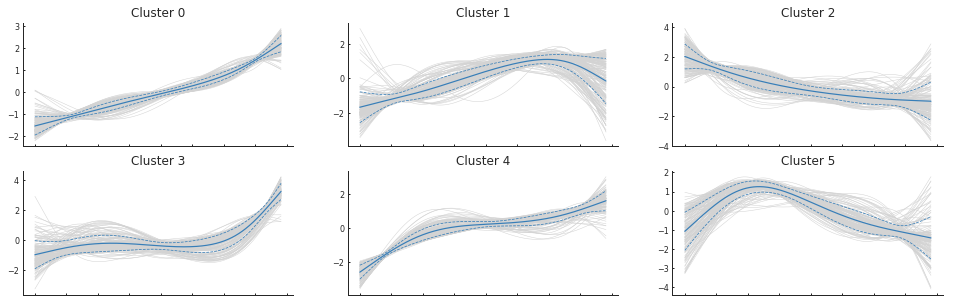

In [30]:
palantir.plot.plot_gene_trend_clusters(trends, gene_clusters)